In [1]:
!pip uninstall  tensorflow-addons keras tensorflow-addons -y
!pip install tensorflow-addons
!pip install "keras<3.0.0" "tensorflow<2.16" "tf-models-official<2.16" mediapipe-model-maker

Found existing installation: keras 3.4.1
Uninstalling keras-3.4.1:
  Successfully uninstalled keras-3.4.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 11.4 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.1.5
    Uninstalling typeguard-4.1.5:
      Successfully uninstalled typeguard-4.1.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.6.4 requires numpy<1.26,>=1.16.0, but you have numpy 1.26.4 which is incompatible.
ydata-profiling 4.6.4 requires typeguard<5,>=4.1.2, but you have typeguard 2.13.3 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.0/58.0 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ | done
INFO: pip is looking at multiple versions of tensorboar

In [2]:
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_addons as tfa
import tensorflow.keras as keras 
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from collections import defaultdict
import json
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import cv2
from tensorflow.keras.optimizers import AdamW
# Plot the model
from tensorflow.keras.utils import plot_model
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, precision_score, recall_score, classification_report

2024-08-16 17:36:29.053070: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-16 17:36:29.053175: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-16 17:36:29.185538: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our Tens

In [3]:
data_dir = '/kaggle/input/data-train-v3/data-process'
datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    validation_split=0.2,
    horizontal_flip=True)

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(64, 64),
    batch_size=64,
    class_mode='sparse',
    subset='training',
    shuffle=True
)
validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(64, 64),
    batch_size=64,
    class_mode='sparse',
    subset='validation',
    shuffle=True
)
print(train_generator.class_indices)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    "/kaggle/input/data-test-v3/data_test_v2",
    target_size=(64, 64),
    batch_size=64,
    class_mode='sparse',
    shuffle=False
)

print(test_generator.class_indices)


Found 10583 images belonging to 9 classes.
Found 2642 images belonging to 9 classes.
{'Blue Lays': 0, 'Coca': 1, 'Colagate': 2, 'Fanta': 3, 'Laybuoy': 4, 'Red Lays': 5, 'Safeguard': 6, 'Sunsil': 7, 'Yen': 8}
Found 1375 images belonging to 9 classes.
{'Blue Lays': 0, 'Coca': 1, 'Colagate': 2, 'Fanta': 3, 'Laybuoy': 4, 'Red Lays': 5, 'Safeguard': 6, 'Sunsil': 7, 'Yen': 8}


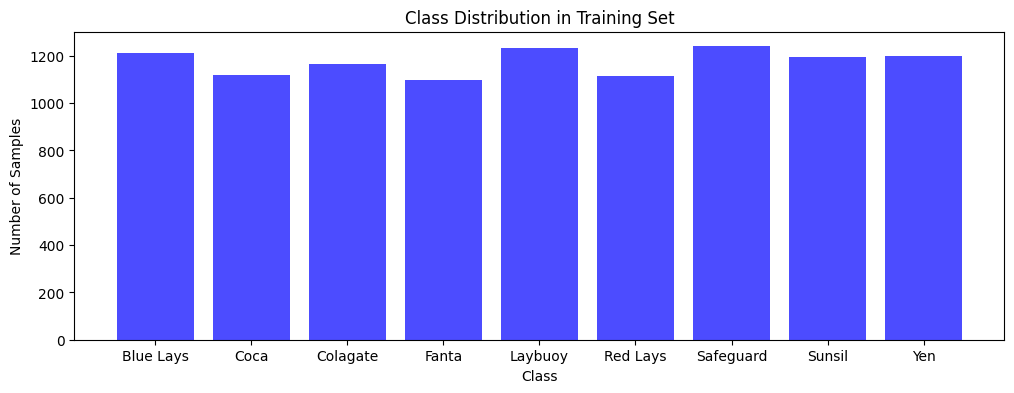

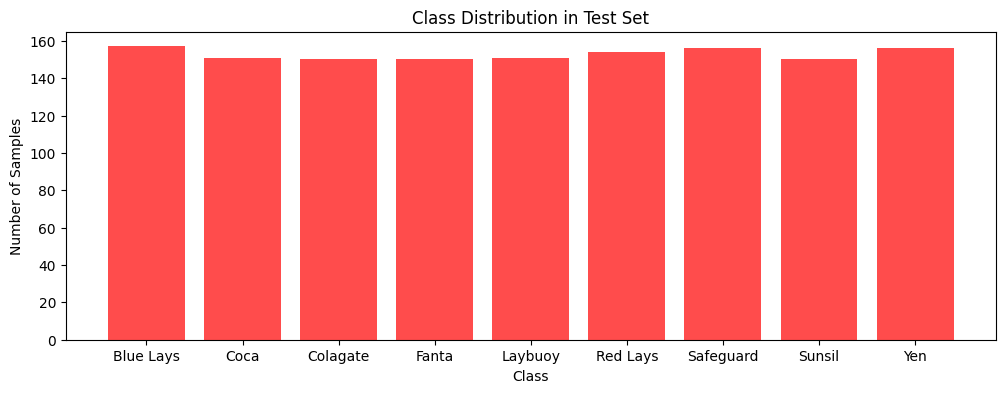

In [4]:
train_labels = train_generator.classes
test_labels = test_generator.classes

class_names = list(train_generator.class_indices.keys())

train_class_counts = np.bincount(train_labels)
test_class_counts = np.bincount(test_labels)

plt.figure(figsize=(12, 4))
plt.bar(class_names, train_class_counts, color='blue', alpha=0.7)
plt.title("Class Distribution in Training Set")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.show()

plt.figure(figsize=(12, 4))
plt.bar(class_names, test_class_counts, color='red', alpha=0.7)
plt.title("Class Distribution in Test Set")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.show()


In [5]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
    )

class MLP(layers.Layer):
    def __init__(self, hidden_units, dropout_rate=0.1):
        super(MLP, self).__init__()
        self.hidden_units = hidden_units
        self.dropout_rate = dropout_rate
        self.dense_layers = [layers.Dense(units, activation=tf.nn.relu) for units in hidden_units]
        self.dropout_layers = [layers.Dropout(dropout_rate) for _ in hidden_units]

    def call(self, x, training=False):
        for dense, dropout in zip(self.dense_layers, self.dropout_layers):
            x = dense(x)
            x = dropout(x, training=training)
        return x

class TransformerEncoderLayer(layers.Layer):
    def __init__(self, num_heads, mlp_dim, dropout, transformer_units):
        super(TransformerEncoderLayer, self).__init__()
        self.num_heads = num_heads
        self.mlp_dim = mlp_dim
        self.dropout = dropout
        self.mlp = MLP(hidden_units=transformer_units, dropout_rate=self.dropout)

    def build(self, input_shape):
        _, num_patches, embed_dim = input_shape
        self.attention = layers.MultiHeadAttention(num_heads=self.num_heads, key_dim=embed_dim)
        
        self.layer_norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layer_norm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate=self.dropout)
        self.dropout2 = layers.Dropout(rate=self.dropout)

    def call(self, inputs, training=False):
        norm = self.layer_norm1(inputs)
        attention_output = self.attention(norm, norm)
        attention_output = self.dropout1(attention_output, training=training)
        attention_output = self.layer_norm2(inputs + attention_output)
        mlp_output = self.mlp(attention_output)
        mlp_output = self.dropout2(mlp_output, training=training)
        mlp_output = attention_output + mlp_output
        return mlp_output

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        height = tf.shape(images)[1]
        width = tf.shape(images)[2]
        channels = tf.shape(images)[3]

        # Extract patches
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID"
        )

        num_patches_height = height // self.patch_size
        num_patches_width = width // self.patch_size
        num_patches = num_patches_height * num_patches_width

        patch_dims = tf.shape(patches)[-1]
        patches = tf.reshape(patches, (batch_size, num_patches, patch_dims))

        return patches
    
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()

        self.num_patches = num_patches
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
            )
    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = patch + self.position_embedding(positions)
        return encoded
    

    
def VisionTransformer(num_classes, num_layers, num_heads, mlp_dim, patch_size, input_shape=(64,64, 3), dropout=0.3):
    inputs = Input(shape=input_shape)
    H, W, C = input_shape
    num_patches_h = H // patch_size
    num_patches_w = W // patch_size
    num_patches = num_patches_h * num_patches_w
    output_dim = patch_size ** 2 * C
    transformer_units = [
            output_dim * 2,
            output_dim,
        ] 
    
    inputs = data_augmentation(inputs)
    # L1 : Create patches
    patches = Patches(patch_size)(inputs)
    # L2 + L7: Encode patches
    encoded_patches = PatchEncoder(num_patches, output_dim)(patches)
    # L3 : Transformer Encoder block
    # Transformer Encoder Blocks
    for _ in range(num_layers):
        encoder = TransformerEncoderLayer(num_heads=num_heads, mlp_dim=mlp_dim, dropout=dropout, transformer_units = transformer_units)
        encoded_patches = encoder(encoded_patches)
        
    # L4 : Create a [batch_size, projection_dim] tensor
    x = tf.reduce_mean(encoded_patches, axis=1)

    # L5 : Add MLP Head
    features = MLP(hidden_units=[1024,512], dropout_rate=dropout)(x)
    # L6 : Classify outputs
    outputs = layers.Dense(units=num_classes, activation='softmax')(features)
    # Create the Keras model
    model = keras.Model(inputs=inputs, outputs=outputs)

    return model

In [6]:
# Instantiate the model
num_classes =9
num_layers = 6
num_heads = 10
mlp_dim = 512
patch_size= 4
# try:
#     loaded_model = load_model("vit_model.h5")
#     vit_model = loaded_model
#     print("Model loaded successfully.")
# except Exception as e:
vit_model = VisionTransformer(num_classes=num_classes,
                              num_layers=num_layers,
                              num_heads=num_heads,
                              mlp_dim=mlp_dim,
                              patch_size = patch_size)

vit_model.compile(optimizer=AdamW(learning_rate=1e-4),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])

# Print the summary
vit_model(tf.zeros([1,64,64,3]))
vit_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 patches (Patches)           (None, 256, 48)           0         
                                                                 
 patch_encoder (PatchEncode  (None, 256, 48)           12288     
 r)                                                              
                                                                 
 transformer_encoder_layer   (None, 256, 48)           103200    
 (TransformerEncoderLayer)                                       
                                                                 
 transformer_encoder_layer_  (None, 256, 48)           103200    
 1 (TransformerEncoderLayer                                      
 )                                                           

In [7]:

filepath="checkpoint.weights.h5"
checkpoint = ModelCheckpoint(filepath,
                             monitor='val_loss',
                             save_best_only=True,
                             save_weights_only=True,
                             mode='max',
                             save_freq='epoch')

early_stop = keras.callbacks.EarlyStopping(monitor='loss',
                                              patience=2)
callbacks_list = [checkpoint, early_stop]

history = vit_model.fit(
    train_generator,
    epochs=100,
    batch_size=64,
    callbacks=callbacks_list,
    validation_data=validation_generator,
)

Epoch 1/100


I0000 00:00:1723829824.576668     127 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


166/166 [==============================] - 87s 402ms/step - loss: 1.4185 - accuracy: 0.4931 - val_loss: 1.1552 - val_accuracy: 0.6033
Epoch 2/100
166/166 [==============================] - 40s 241ms/step - loss: 0.7523 - accuracy: 0.7238 - val_loss: 0.8574 - val_accuracy: 0.7165
Epoch 3/100
166/166 [==============================] - 40s 242ms/step - loss: 0.5171 - accuracy: 0.8076 - val_loss: 0.5295 - val_accuracy: 0.7835
Epoch 4/100
166/166 [==============================] - 40s 242ms/step - loss: 0.3737 - accuracy: 0.8624 - val_loss: 0.4755 - val_accuracy: 0.8191
Epoch 5/100
166/166 [==============================] - 41s 249ms/step - loss: 0.2924 - accuracy: 0.8932 - val_loss: 0.4384 - val_accuracy: 0.8380
Epoch 6/100
166/166 [==============================] - 41s 246ms/step - loss: 0.2307 - accuracy: 0.9130 - val_loss: 0.3366 - val_accuracy: 0.8751
Epoch 7/100
166/166 [==============================] - 40s 241ms/step - loss: 0.1793 - accuracy: 0.9293 - val_loss: 0.1934 - val_accurac

In [8]:
for x_batch, y_batch in train_generator:
    print("Shape of y_batch:", tf.shape(y_batch))
    break

Shape of y_batch: tf.Tensor([64], shape=(1,), dtype=int32)


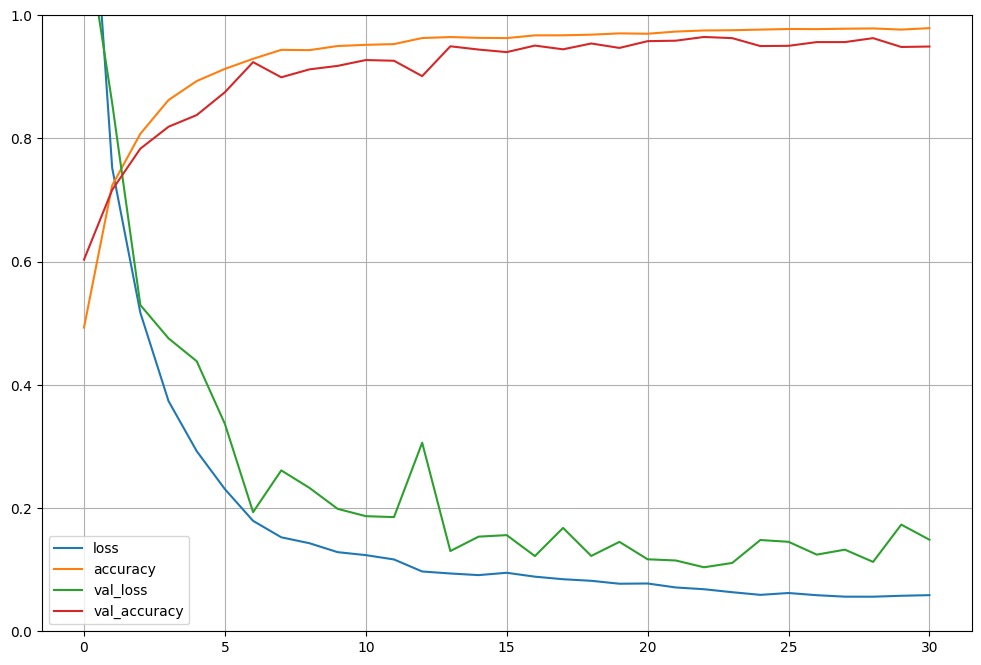

In [9]:
# plot the learning curves
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(12, 8))
plt.grid(True)
plt.gca().set_ylim(0, 1) 
plt.show()

In [10]:
vit_model.save("vit_v4_9_label_006_097_014_096")
import shutil
folder_path = '/kaggle/working/vit_v4_9_label_006_097_014_096'
zip_file_path = '/kaggle/working/vit_v4_9_label_006_097_014_096.zip'
shutil.make_archive('/kaggle/working/vit_v4_9_label_006_097_014_096', 'zip', folder_path)

'/kaggle/working/vit_v4_9_label_006_097_014_096.zip'

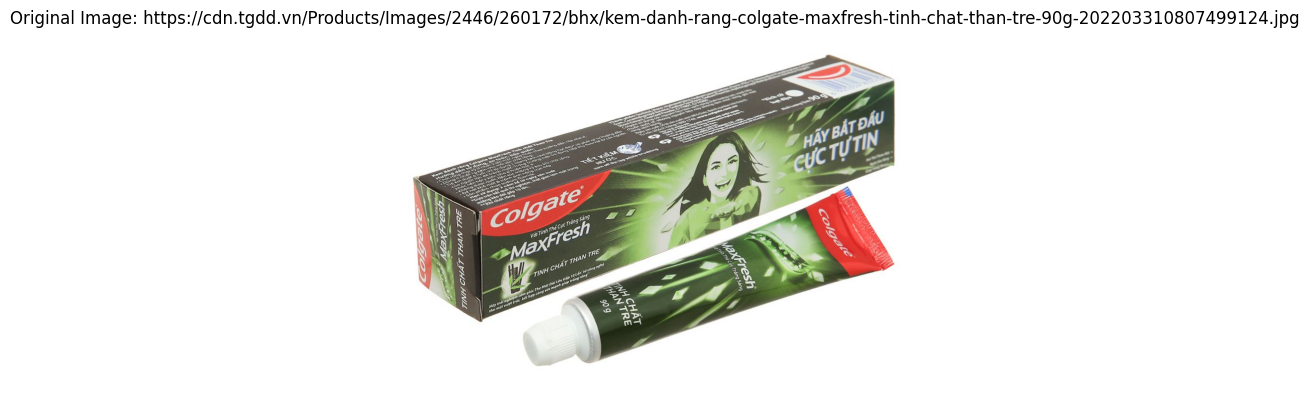

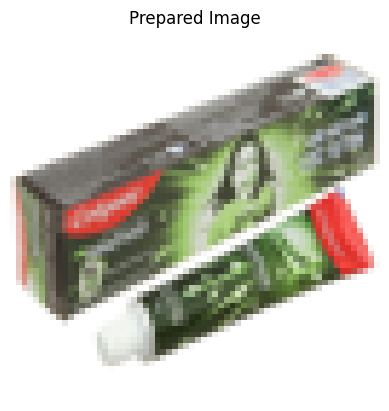

1/1 [==============================] - 1s 797ms/step
[[7.8986675e-09 1.5839454e-09 9.9994910e-01 3.2698486e-09 6.5622414e-09
  1.6186699e-10 2.9726269e-05 7.4908172e-08 2.1129901e-05]]
(1, 9)
Kết quả dự đoán: 2, Xác suất: 0.9999490976333618


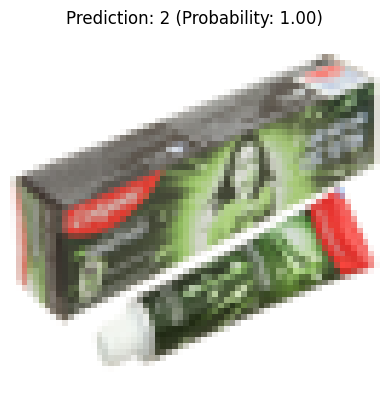

In [12]:
import requests
from PIL import Image
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from io import BytesIO

def load_and_prepare_image_from_url(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert('RGB')  
    img = img.resize((64, 64)) 
    img = np.array(img).astype('float32') / 255.0
    img = np.expand_dims(img, axis=0)  
    return img

# Hàm để kiểm tra hình ảnh sau khi tải và chuẩn bị
def check_image_from_url(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    plt.imshow(img)
    plt.title(f'Original Image: {url}')
    plt.axis('off')
    plt.show()

# URL của hình ảnh
url = 'https://cdn.tgdd.vn/Products/Images/2446/260172/bhx/kem-danh-rang-colgate-maxfresh-tinh-chat-than-tre-90g-202203310807499124.jpg'

check_image_from_url(url)

x_test2 = load_and_prepare_image_from_url(url)

if x_test2 is None or x_test2.shape != (1, 64, 64, 3):
    print("Có lỗi khi chuẩn bị hình ảnh đầu vào.")
else:
    plt.imshow(x_test2[0])
    plt.title('Prepared Image')
    plt.axis('off')
    plt.show()
    
    try:
        y_pred2 = vit_model.predict(x_test2)
        print(y_pred2)
        y_pred2_max_index = np.argmax(y_pred2, axis=1)[0]
        y_pred2_max_value = np.max(y_pred2)
        print(y_pred2.shape)
        print(f'Kết quả dự đoán: {y_pred2_max_index}, Xác suất: {y_pred2_max_value}')
        
        plt.imshow(x_test2[0])
        plt.title(f'Prediction: {y_pred2_max_index} (Probability: {y_pred2_max_value:.2f})')
        plt.axis('off')
        plt.show()
    except Exception as e:
        print(f"Có lỗi xảy ra khi dự đoán: {e}")

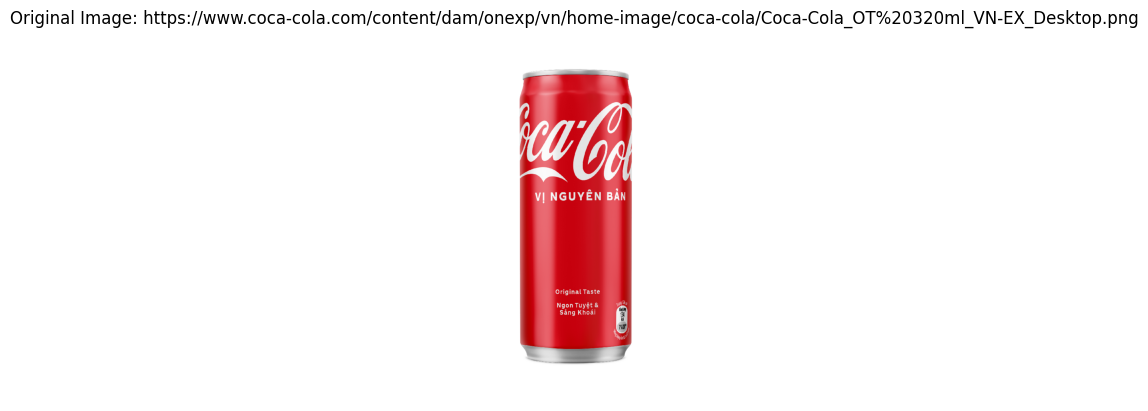

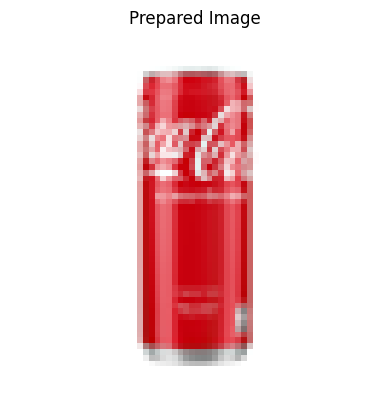

1/1 [==============================] - 0s 25ms/step
[[3.8306133e-11 9.9997675e-01 2.0225976e-09 2.3154131e-05 1.6708487e-08
  2.4544830e-08 1.9835426e-08 1.2597322e-08 1.4661293e-10]]
(1, 9)
Kết quả dự đoán: 1, Xác suất: 0.9999767541885376


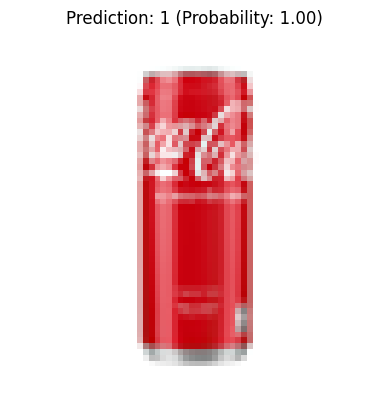

In [13]:
import requests
from PIL import Image
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from io import BytesIO

def load_and_prepare_image_from_url(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert('RGB')  
    img = img.resize((64, 64))  
    img = np.array(img).astype('float32') / 255.0  
    img = np.expand_dims(img, axis=0)  
    return img

def check_image_from_url(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    plt.imshow(img)
    plt.title(f'Original Image: {url}')
    plt.axis('off')
    plt.show()

url = 'https://www.coca-cola.com/content/dam/onexp/vn/home-image/coca-cola/Coca-Cola_OT%20320ml_VN-EX_Desktop.png'

check_image_from_url(url)

x_test2 = load_and_prepare_image_from_url(url)

if x_test2 is None or x_test2.shape != (1, 64, 64, 3):
    print("Có lỗi khi chuẩn bị hình ảnh đầu vào.")
else:
    plt.imshow(x_test2[0])
    plt.title('Prepared Image')
    plt.axis('off')
    plt.show()
    
    try:
        y_pred2 = vit_model.predict(x_test2)
        print(y_pred2)
        y_pred2_max_index = np.argmax(y_pred2, axis=1)[0]
        y_pred2_max_value = np.max(y_pred2)
        print(y_pred2.shape)
        print(f'Kết quả dự đoán: {y_pred2_max_index}, Xác suất: {y_pred2_max_value}')
        
        plt.imshow(x_test2[0])
        plt.title(f'Prediction: {y_pred2_max_index} (Probability: {y_pred2_max_value:.2f})')
        plt.axis('off')
        plt.show()
    except Exception as e:
        print(f"Có lỗi xảy ra khi dự đoán: {e}")

22/22 [==============================] - 7s 277ms/step
Classification Report:
              precision    recall  f1-score   support

   Blue Lays       0.99      0.85      0.91       157
        Coca       0.87      0.91      0.89       151
    Colagate       0.75      0.68      0.71       150
       Fanta       0.91      1.00      0.95       150
     Laybuoy       0.98      0.70      0.81       151
    Red Lays       0.94      0.97      0.96       154
   Safeguard       0.76      0.97      0.85       156
      Sunsil       0.93      0.97      0.95       150
         Yen       0.83      0.85      0.84       156

    accuracy                           0.88      1375
   macro avg       0.88      0.88      0.88      1375
weighted avg       0.88      0.88      0.88      1375



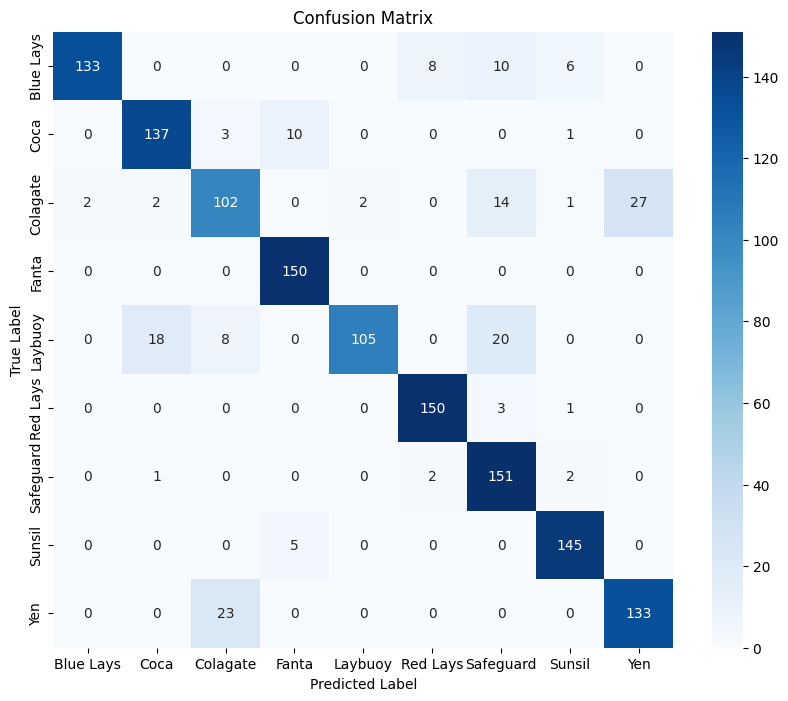

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

predictions = vit_model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()